##Illustrating Basic Bayesian Optimization

There are multiple open source packages for bayesian optimization, the two most prominent being MOE (Metric Optimization Engine, produced by Yelp) and Spearmint (from the Harvard research group HIPS). In this notebook I decided to use MOE because I found it to be better documented and easier to use.

MOE: https://github.com/Yelp/MOE

Spearmint: https://github.com/HIPS/Spearmint

In [1]:
from moe.easy_interface.experiment import Experiment
from moe.easy_interface.simple_endpoint import gp_next_points
from moe.optimal_learning.python.data_containers import SamplePoint
import random
import numpy as np

First we have to import the relevant functions. It is important to note that moe has a python interface, but must be installed and running in docker.

Now let's define an objective function which we're aiming to optimize. To MOE, this function is a black-box. In a machine learning context, this is a measure of the goodness of your models fit to the data and might be something like the root mean square error. As a side note, MOE by default will try to minimize the objective; if you have a metric you are trying to maximize (say R-squared), you simply make your objective function the negative of this metric.

In [2]:
def objective(X):
    '''
    some black-box objective function we are trying to optimize with random noise
    '''
    return X[0]**2 + X[1]**2 + np.sin(X[2]) + random.uniform(-2, 2)

Next we initialize an 'Experiment' by giving MOE the ranges of its relevant parameters (in practice this might be the hyperparameters of our model).

In [39]:
exp = Experiment([[-5,5], [-5,5], [-5,5]])

We can now retrieve our first point to sample.  Since we have no data to sample, this is just a random point.

In [4]:
next_point_to_sample = gp_next_points(exp)[0]
next_point_to_sample

[-2.19831762162, -3.45358026823, 4.74534360143]

So let's determine the value of this next point to sample (train our model using the given hyperparameters and retrieve our goodness-of-fit measure)

In [5]:
value_of_next_point = objective(next_point_to_sample)
value_of_next_point

16.62807030393417

However this value won't necessarily be perfectly deterministic. Let's sample the objective function five times, taking the mean and the variance (you can think of this as a stand in for five-fold cross validation) ...

In [6]:
objective_values = [objective(next_point_to_sample) for i in range(5)]
mean_next_point = np.mean(objective_values)
var_next_point = np.var(objective_values)
print objective_values, '\n'
print mean_next_point, '\t', var_next_point

[16.105352252986592, 16.551065529575066, 14.394371147077806, 15.051770228649115, 16.204772293854731] 

15.6614662904 	0.652172471491


... and return this value to MOE.

In [7]:
exp.historical_data.append_sample_points([SamplePoint(next_point_to_sample, 
                                                      mean_next_point,
                                                      var_next_point)])

MOE has now updated its model of the response curve to account for the new information and will provide an updated point of maximum expected improvement.  Also note that if you want to implement bayesian optimization on a process for which you already have historical data, these points can be used to update your model in the same way.

Now we can retrieve our next sample point and repeat.

In [8]:
next_point_to_sample = gp_next_points(exp)[0]
next_point_to_sample

[3.53687940437, 2.24664798986, -0.941334120568]

###Visualizing a 1D Example

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import time

We'll define some some functions to help plot and run MOE, as well as our 1-D input objective function with noise.

In [10]:
def plot(x,y):
    plt.plot([i for i in range(-6,7)], [i**2 for i in range(-6,7)])
    plt.plot(x,y,'.',markersize=10)
    plt.axis([-6,6,-3,28])
    plt.xlabel('Hyperparameter')
    plt.ylabel('Objective Function')
    plt.grid(b=True, which='both', color='0.65',linestyle='-')

In [11]:
def objective(X):
    return X[0]**2 + random.uniform(-2, 2)

In [12]:
def sample_and_update(x, y, exp):
    next_point_to_sample = gp_next_points(exp)[0]
    objective_values = [objective(next_point_to_sample) for i in range(5)]
    mean_next_point = np.mean(objective_values)
    var_next_point = np.var(objective_values)
    x.append(next_point_to_sample)
    y.append(mean_next_point)
    exp.historical_data.append_sample_points([SamplePoint(next_point_to_sample, 
                                                      mean_next_point,
                                                      var_next_point)])
    return x, y, exp

Initialize our experiment and x and y values

In [13]:
exp = Experiment([[-5,5]])
x = []
y = []

And visualize how MOE samples the space and the results it finds (the underlying function has also been plotted in blue, but MOE has no knowledge of this function)

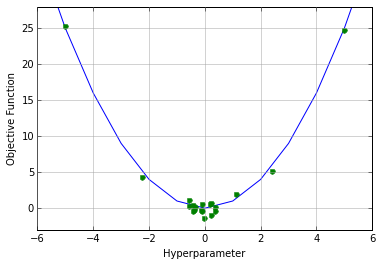

In [15]:
exp = Experiment([[-5,5]])
x = []
y = []
for i in range(20):
    x,y,exp = sample_and_update(x,y,exp)
    plot(x,y)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.0)
    plt.close()

You can see the tradeoff between exploration and exploitation being made as MOE finds the underlying minimum.

Note that the initial point search is random (plus we have random noise) so you will get a slightly different exploration of the space every time this is run

Now let's look at how it explores a different underlying objective with multiple potential minima:

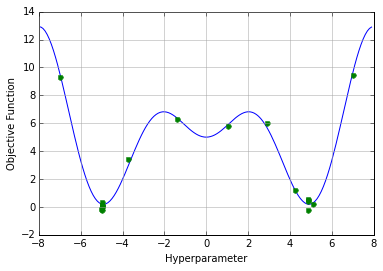

In [34]:
def plot(x,y):
    plt.plot([i/10. for i in range(-80,80)], [i/10.*np.sin(i/10.)+5  for i in range(-80,80)])
    plt.plot(x,y,'.',markersize=10)
    plt.axis([-8,8,-2,14])
    plt.xlabel('Hyperparameter')
    plt.ylabel('Objective Function')
    plt.grid(b=True, which='both', color='0.65',linestyle='-')
def objective(X):
    return X[0]*np.sin(X[0]) + 5 + random.uniform(-1, 1)
exp = Experiment([[-7,7]])
x = []
y = []
for i in range(20):
    x,y,exp = sample_and_update(x,y,exp)
    plot(x,y)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.0)
    plt.close()

You can see how it performs a rough search of the space before it zooms in on the areas of highest probability